# Test For `ModelDriftChecker`-`pydrift` 

We're going to test how it works with the famous titanic dataset

# Dependencies

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from pydrift.core.drift_checker import ModelDriftChecker
from pydrift.constants import PATH_DATA, RANDOM_STATE
from pydrift.models import cat_features_fillna

# Read Data 

In [2]:
df_titanic = pd.read_csv(PATH_DATA / 'titanic.csv')

# Constants 

In [3]:
TARGET = 'Survived'

# Model Training 

In [4]:
X = df_titanic.drop(columns=['PassengerId', TARGET])
y = df_titanic[TARGET]

cat_features = (X
                .select_dtypes(include=['category', 'object'])
                .columns)

X_filled = cat_features_fillna(X, cat_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_filled, y, test_size=.5, random_state=RANDOM_STATE, stratify=y
)

ml_classifier_model = CatBoostClassifier(
    num_trees=5,
    max_depth=3,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    verbose=False
)

ml_classifier_model.fit(X_train, y_train);

# Instanciate `pydrift.DataDriftChecker` 

In [5]:
df_left_data = pd.concat([X_train, y_train], axis=1)
df_right_data = pd.concat([X_test, y_test], axis=1)
    
model_drift_checker_ok = ModelDriftChecker(
    df_left_data, df_right_data, ml_classifier_model, target_column_name=TARGET
)

# Test  `ml_model_can_discriminate` Feature

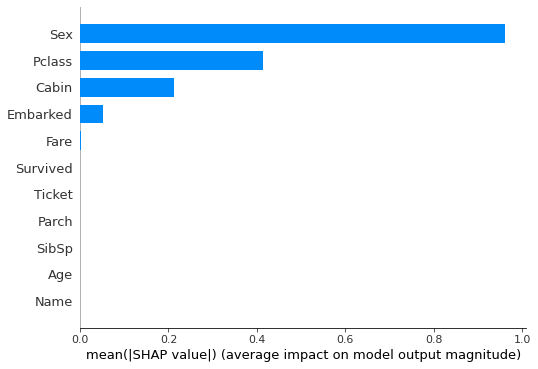

No drift found in your model

AUC left data: 0.8429909932983308
AUC right data: 0.8432429558745349


In [6]:
model_drift_checker_ok.check_model();

# Same But  Make It Drift

We will force model drift with a complex model (higher hyperparameters)

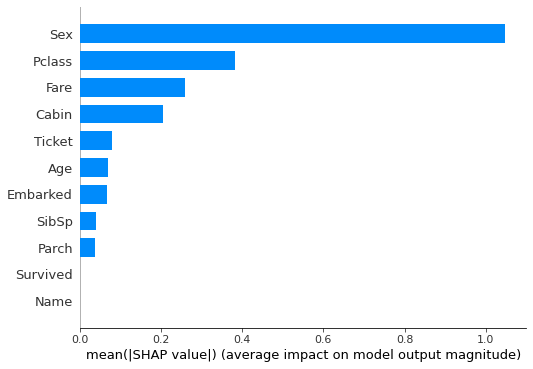

Drift found in your model, take a look on the most discriminative features (plots when minimal is set to False), DataDriftChecker can help you with changes in features distribution and also look at your hyperparameters

AUC left data: 0.9080548085542323
AUC right data: 0.8590430622009568


In [7]:
ml_classifier_model_drifted = CatBoostClassifier(
    num_trees=10,
    max_depth=6,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    verbose=False
)

ml_classifier_model_drifted.fit(X_train, y_train)

model_drift_checker_ko = ModelDriftChecker(
    df_left_data, df_right_data, ml_classifier_model_drifted, target_column_name=TARGET
)

model_drift_checker_ko.check_model();

# Checking Most Important Features Histograms

`Sex` column is the most important one but no differences because model drift is caused by model hyperparameters

In [8]:
model_drift_checker_ko.interpretable_drift_classifier_model.both_histogram_plot('Sex').show(renderer='iframe')

# Drift With Data, Not With Model Params

This is because you cannot see differences in the histograms because the problem is in your model params, not in the data

## We Use The Non-Drifted Model But We Will Drift The Data

If we drifted the dataset giving it a feature-related bias we can see differences

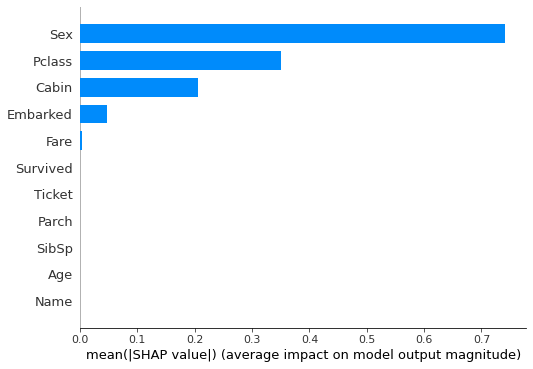

Drift found in your model, take a look on the most discriminative features (plots when minimal is set to False), DataDriftChecker can help you with changes in features distribution and also look at your hyperparameters

AUC left data: 0.8446861131656805
AUC right data: 0.6408220965637234


In [9]:
df_left_data_drifted = df_left_data[(df_left_data['Sex'] == 'female') | (df_left_data['SibSp'] < 2)]
df_right_data_drifted = df_right_data[(df_right_data['Sex'] == 'male') | (df_right_data['SibSp'] > 1)]

model_drift_checker_ko_2 = ModelDriftChecker(
    df_left_data_drifted, df_right_data_drifted, ml_classifier_model, target_column_name=TARGET
)

model_drift_checker_ko_2.check_model();

# Checking Most Important Features Histograms

`Sex` column is the most important one

In [10]:
model_drift_checker_ko_2.interpretable_drift_classifier_model.both_histogram_plot('Sex').show(renderer='iframe')